# Homomorphic Encryption in Logistic Regression

## Install Third Party Library

In [4]:
!pip install torch torchmetrics tenseal

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import random
import time
import torch
import pandas as pd
import tenseal as ts

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from torchmetrics.classification import BinaryF1Score

import seaborn as sns
import matplotlib.pyplot as plt

## Load Dataset

In [6]:
torch.random.manual_seed(42)
random.seed(42)

# Load dataset from csv
df = pd.read_csv("./framingham.csv")

df.describe()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,4238.000000,4238.000000,4133.000000,4238.000000,4209.000000,4185.000000,4238.000000,4238.000000,4238.000000,4188.000000,4238.000000,4238.000000,4219.000000,4237.000000,3850.000000,4238.000000
mean,0.429212,49.584946,1.978950,0.494101,9.003089,0.029630,0.005899,0.310524,0.025720,236.721585,132.352407,82.893464,25.802008,75.878924,81.966753,0.151958
std,0.495022,8.572160,1.019791,0.500024,11.920094,0.169584,0.076587,0.462763,0.158316,44.590334,22.038097,11.910850,4.080111,12.026596,23.959998,0.359023
min,0.000000,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,107.000000,83.500000,48.000000,15.540000,44.000000,40.000000,0.000000
25%,0.000000,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.000000,75.000000,23.070000,68.000000,71.000000,0.000000
50%,0.000000,49.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.000000,82.000000,25.400000,75.000000,78.000000,0.000000
75%,1.000000,56.000000,3.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,263.000000,144.000000,89.875000,28.040000,83.000000,87.000000,0.000000
max,1.000000,70.000000,4.000000,1.000000,70.000000,1.000000,1.000000,1.000000,1.000000,696.000000,295.000000,142.500000,56.800000,143.000000,394.000000,1.000000


[]

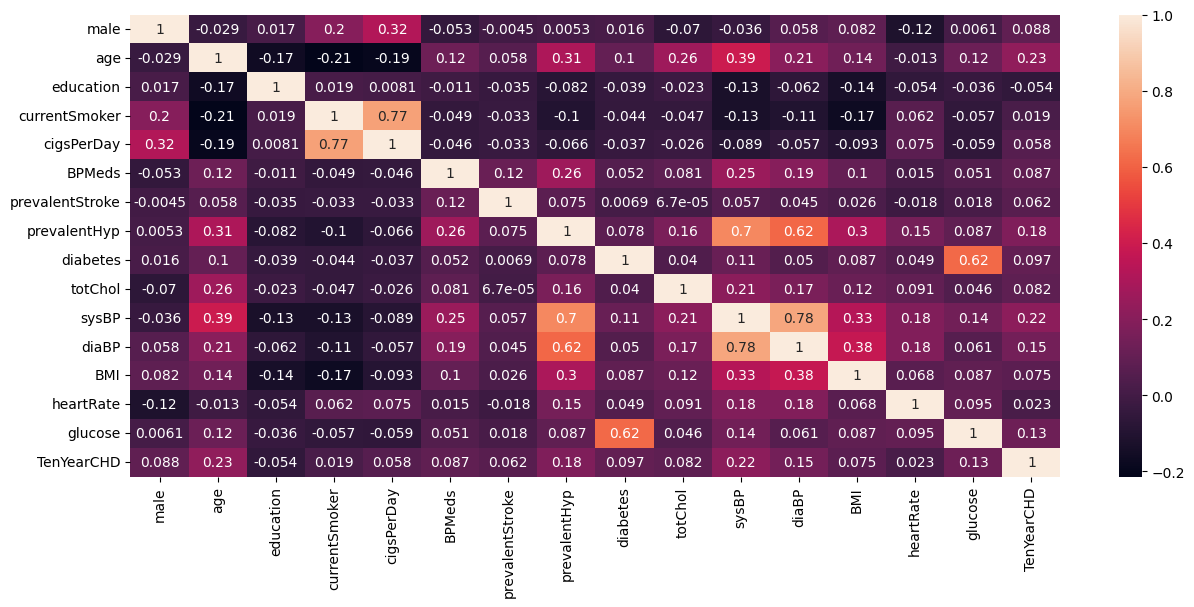

In [7]:
# Plot Heatmap of Correlation
corr = df.corr()
fig, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(corr, ax=ax, xticklabels=corr.columns, yticklabels=corr.columns, annot=True)
plt.plot()

In [8]:
# Add Column yang menggabungkan beberapa Column lainnya
df["meanArterialPressure"] = df["diaBP"] + (df["sysBP"] - df["diaBP"]) / 3

# Drop Column yang dapat diinferensikan dari Column lainnya
df = df.drop(columns=[
    "prevalentHyp", # Dapat diinferensikan dari sysBP dan diaBP
    "diabetes", # Dapat diinferensikan dari glucose
    "currentSmoker", # Dapat diinferensikan dari cigsPerDay
    "sysBP", # Dapat diinferensikan dari meanArterialPressure
    "diaBP", # Dapat diinferensikan dari meanArterialPressure
])

df.describe()

,male,age,education,cigsPerDay,BPMeds,prevalentStroke,totChol,BMI,heartRate,glucose,TenYearCHD,meanArterialPressure
count,4238.000000,4238.000000,4133.000000,4209.000000,4185.000000,4238.000000,4188.000000,4219.000000,4237.000000,3850.000000,4238.000000,4238.000000
mean,0.429212,49.584946,1.978950,9.003089,0.029630,0.005899,236.721585,25.802008,75.878924,81.966753,0.151958,99.379778
std,0.495022,8.572160,1.019791,11.920094,0.169584,0.076587,44.590334,4.080111,12.026596,23.959998,0.359023,14.438873
min,0.000000,32.000000,1.000000,0.000000,0.000000,0.000000,107.000000,15.540000,44.000000,40.000000,0.000000,62.500000
25%,0.000000,42.000000,1.000000,0.000000,0.000000,0.000000,206.000000,23.070000,68.000000,71.000000,0.000000,89.500000
50%,0.000000,49.000000,2.000000,0.000000,0.000000,0.000000,234.000000,25.400000,75.000000,78.000000,0.000000,97.333333
75%,1.000000,56.000000,3.000000,20.000000,0.000000,0.000000,263.000000,28.040000,83.000000,87.000000,0.000000,107.125000
max,1.000000,70.000000,4.000000,70.000000,1.000000,1.000000,696.000000,56.800000,143.000000,394.000000,1.000000,188.333333


[]

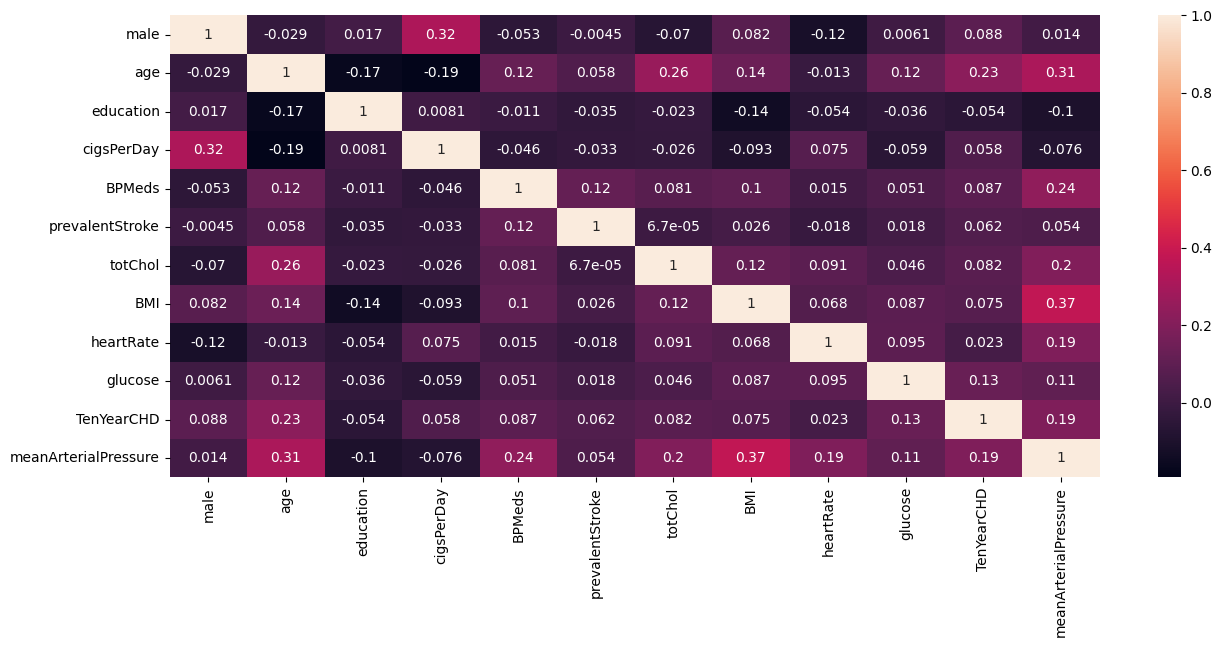

In [9]:
# Plot Heatmap of Correlation of Dropped Column
corr = df.corr()
fig, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(corr, ax=ax, xticklabels=corr.columns, yticklabels=corr.columns, annot=True)
plt.plot()

## Data Cleaning, Sampling, and Standarizing

In [10]:
# Drop Missing Value
print(f"Null Values:\n{df.isnull().sum()}")

df = df.dropna()

Null Values:
male                      0
age                       0
education               105
cigsPerDay               29
BPMeds                   53
prevalentStroke           0
totChol                  50
BMI                      19
heartRate                 1
glucose                 388
TenYearCHD                0
meanArterialPressure      0
dtype: int64


In [11]:
# Drop Duplicate
duplicate_df = df[df.duplicated()]
print(f"Number of Duplicates: {len(duplicate_df)}")

df = df.drop_duplicates()

Number of Duplicates: 0


In [12]:
# Split X and y values
X = df.drop(columns=["TenYearCHD"])
y = df["TenYearCHD"].copy()

In [13]:
# Random Undersampling (reduce training time)
undersampler = RandomUnderSampler(random_state=42)
X, y = undersampler.fit_resample(X, y)

In [14]:
# Standardize non-categorical X values
scaler = MinMaxScaler()

for col in ["age", "education", "cigsPerDay", "totChol", "BMI", "heartRate", "glucose", "meanArterialPressure"]:
    X[col] = scaler.fit_transform(X[[col]])

X.describe()

,male,age,education,cigsPerDay,BPMeds,prevalentStroke,totChol,BMI,heartRate,glucose,meanArterialPressure
count,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000
mean,0.479354,0.530739,0.300419,0.138394,0.045781,0.009874,0.247716,0.251085,0.330530,0.125884,0.317292
std,0.499798,0.231672,0.342512,0.177958,0.209104,0.098922,0.096504,0.106365,0.126662,0.088679,0.131203
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.351351,0.000000,0.000000,0.000000,0.000000,0.182773,0.177032,0.242105,0.090395,0.223841
50%,0.000000,0.540541,0.333333,0.000000,0.000000,0.000000,0.242647,0.242042,0.315789,0.107345,0.298675
75%,1.000000,0.729730,0.666667,0.285714,0.000000,0.000000,0.300420,0.308276,0.418421,0.135593,0.390728
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
# Split for Training and Testing

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Training Logistic Regression on Unencrypted Data

### Determine Device used for Training

In [16]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


### Define the Logistic Regression Model

In [17]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, n_features):
        super(LogisticRegression, self).__init__()
        self.layer = torch.nn.Linear(n_features, 1)
        
    def forward(self, x):
        out = torch.sigmoid(self.layer(x))
        return out

_, column = X_train.shape
logistic_regression = LogisticRegression(column).to(device)

### Transform Learning Data to Tensor

In [18]:
tensor_X_train = torch.tensor(X_train.values).to(torch.float32)
tensor_X_test = torch.tensor(X_test.values).to(torch.float32)
tensor_y_train = torch.tensor(y_train.values).to(torch.float32).unsqueeze(1)
tensor_y_test = torch.tensor(y_test.values).to(torch.float32).unsqueeze(1)

print(f"X train: {tensor_X_train.shape} {tensor_X_train.dtype}")
print(f"X test: {tensor_X_test.shape} {tensor_X_test.dtype}")
print(f"y train: {tensor_y_train.shape} {tensor_y_train.dtype}")
print(f"y test: {tensor_y_test.shape} {tensor_y_test.dtype}")

X train: torch.Size([891, 11]) torch.float32
X test: torch.Size([223, 11]) torch.float32
y train: torch.Size([891, 1]) torch.float32
y test: torch.Size([223, 1]) torch.float32


### Define a Loss Function and an Optimizer

In [19]:
# Use Stochastic Gradient Descent
optim = torch.optim.SGD(logistic_regression.parameters(), lr=1)

# Use Binary Cross Entropy Loss
criterion = torch.nn.BCELoss()

### Define Train and Test Function

In [20]:
def train(model, optim, criterion, X, y):
    start_time = time.perf_counter()

    model.train()
    X, y = X.to(device), y.to(device)

    # Compute prediction error
    pred = model(X)
    loss = criterion(pred, y)

    # Backpropagation
    loss.backward()
    optim.step()
    optim.zero_grad()

    end_time = time.perf_counter()

    print(f"Loss: {loss:>7f}")
    print(f"Time Taken: {end_time - start_time:>2f} s")

In [21]:
def test(model, X, y):
    start_time = time.perf_counter()

    model.eval()
    X, y = X.to(device), y.to(device)

    # Compute prediction
    pred = model(X)
    f1_score = BinaryF1Score().to(device)

    end_time = time.perf_counter()

    print(f"F1 Score: {f1_score(pred, y).item():>4f}")
    print(f"Time Taken: {end_time - start_time:>2f} s")

### Train the Model

In [22]:
EPOCHS = 5

# Train in Epochs
for e in range(EPOCHS):
    print(f"Epoch {e + 1}\n-------------------------------")
    train(logistic_regression, optim, criterion, tensor_X_train, tensor_y_train)
    print()

Epoch 1
-------------------------------
Loss: 0.699757
Time Taken: 3.040356 s

Epoch 2
-------------------------------
Loss: 0.685218
Time Taken: 0.001012 s

Epoch 3
-------------------------------
Loss: 0.680260
Time Taken: 0.001032 s

Epoch 4
-------------------------------
Loss: 0.677913
Time Taken: 0.000959 s

Epoch 5
-------------------------------
Loss: 0.676272
Time Taken: 0.000932 s



In [23]:
# Get F1 Score from Model

test(logistic_regression, tensor_X_test, tensor_y_test)

F1 Score: 0.674330
Time Taken: 0.002502 s


## Training Logistic Regression on Encrypted Data

### Setup Encryption Parameters

In [105]:
# Parameters
poly_mod_degree = 16384
coeff_mod_bit_sizes = [60, 40, 40, 40, 40, 40, 40, 40, 60]

# Create TenSEALContext
ctx_training = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
ctx_training.global_scale = 2 ** 40
ctx_training.generate_galois_keys()

### Determine the Approximation of Sigmoid Function

According to this [paper](https://eprint.iacr.org/2018/462.pdf), we can approximate the sigmoid function accurately with $f(x) \approx -0.004x^3 + 0.197x +0.5, x \in [-5, 5]$ using Remez algorithm, which is an iterative minimax approximation algorithm.

In [106]:
weight = logistic_regression.layer.weight.data.tolist()[0] # Convert from tensor to list
bias = logistic_regression.layer.bias.data.tolist()

print(f"Weight: {weight}")
print(f"Bias: {bias}")

Weight: [0.2106858491897583, 0.27098724246025085, -0.17342333495616913, 0.2575427293777466, -0.02136250212788582, 0.06753615289926529, -0.19143564999103546, 0.1304694563150406, 0.1681479811668396, -0.22633618116378784, 0.2356201410293579]
Bias: [-0.2182490974664688]


### Encode the Train dataset

In [107]:
start_time = time.perf_counter()

encoded_X_train = [ts.ckks_vector(ctx_training, data) for data in X_train.values]

end_time = time.perf_counter()

print(f"Time Taken: {end_time - start_time:>2f} s")

Time Taken: 21.417057 s


In [108]:
start_time = time.perf_counter()

encoded_X_test = [ts.ckks_vector(ctx_training, data) for data in X_test.values]

end_time = time.perf_counter()

print(f"Time Taken: {end_time - start_time:>2f} s")

Time Taken: 5.328839 s


In [109]:
start_time = time.perf_counter()

encoded_y_train = [ts.ckks_vector(ctx_training, [data]) for data in y_train.values]

end_time = time.perf_counter()

print(f"Time Taken: {end_time - start_time:>2f} s")

Time Taken: 20.399485 s


In [110]:
start_time = time.perf_counter()

encoded_y_test = [ts.ckks_vector(ctx_training, [data]) for data in y_test.values]

end_time = time.perf_counter()

print(f"Time Taken: {end_time - start_time:>2f} s")

Time Taken: 5.300800 s


### Define Encrypted Logistic Regression Model

In [111]:
class EncryptedLogisticRegression:
    def __init__(self, context, n_features):
        self.weight = [0 for _ in range(n_features)]
        self.bias = [0]
        self.__delta_weight = 0
        self.__delta_bias = 0
        self.__count = 0

    def sigmoid(self, encrypted_x):
        # According to the approximation explained beforehand
        return encrypted_x.polyval([0.5, 0.197, 0, -0.004])

    def forward(self, encrypted_x):
        encrypted_out = encrypted_x.dot(self.weight) + self.bias
        encrypted_out = self.sigmoid(encrypted_out)
        return encrypted_out

    def forward_with_plaintext(self, x):
        tensor_w = torch.tensor(self.weight, dtype=torch.float32)
        tensor_b = torch.tensor(self.bias, dtype=torch.float32)
        out = torch.sigmoid(x.matmul(tensor_w)+ tensor_b).reshape(-1, 1)
        return out

    def backward(self, encrypted_x, encrypted_out, encrypted_y):
        out_minus_y = encrypted_out - encrypted_y
        self.__delta_weight += encrypted_x * out_minus_y
        self.__delta_bias += out_minus_y
        self.__count += 1

    def update_parameters(self, learning_rate, regularization_parameter):
        assert self.__count > 0

        # Assume lambda / m = 0.05 (to avoid overfitting)
        self.weight -= learning_rate * (self.__delta_weight * (1 / self.__count) + regularization_parameter * self.weight)
        self.bias -= learning_rate * (self.__delta_bias * (1 / self.__count))

        # Reset delta values
        self.__delta_weight = 0
        self.__delta_bias = 0
        self.__count = 0

    def encrypt(self, context):
        self.weight = ts.ckks_vector(context, self.weight)
        self.bias = ts.ckks_vector(context, self.bias)

    def decrypt(self):
        self.weight = self.weight.decrypt()
        self.bias = self.bias.decrypt()

    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

_, column = X_train.shape
encrypted_logistic_regression = EncryptedLogisticRegression(ctx_training, column)

### Define Train and Test Function

In [112]:
def train(model, encrypted_data, encrypted_target, learning_rate, regularization_parameter):
    start_time = time.perf_counter()

    for encrypted_X, encrypted_y in zip(encrypted_data, encrypted_target):
        encrypted_out = model(encrypted_X)
        model.backward(encrypted_X, encrypted_out, encrypted_y)

    model.update_parameters(learning_rate, regularization_parameter)
    end_time = time.perf_counter()

    print(f"Time Taken: {end_time - start_time:>2f} s")

In [113]:
def test(model, data, target):
    start_time = time.perf_counter()

    # Compute prediction
    pred = model.forward_with_plaintext(data)
    f1_score = BinaryF1Score()

    # Print the result
    print(f"F1 Score: {f1_score(pred, target).item():>4f}")

    end_time = time.perf_counter()

    print(f"Time Taken: {end_time - start_time:>2f} s")

### Train the Model

In [114]:
EPOCHS = 5 # Limited resource because took so long
learning_rate = 1
regularization_parameter = 0.05

# Server train the model using context sent from user
for e in range(EPOCHS):
    print(f"Epoch {e + 1}\n-------------------------------")
    encrypted_logistic_regression.encrypt(ctx_training) # User sent context are cached in server
    
    train(encrypted_logistic_regression, encoded_X_train, encoded_y_train, learning_rate, regularization_parameter)
    encrypted_logistic_regression.decrypt()

    print()

Epoch 1
-------------------------------
Time Taken: 290.044480 s

Epoch 2
-------------------------------
Time Taken: 289.288920 s

Epoch 3
-------------------------------
Time Taken: 289.419346 s

Epoch 4
-------------------------------
Time Taken: 288.835741 s

Epoch 5
-------------------------------
Time Taken: 287.516435 s



In [115]:
# Client test the model using unencrypted data or infer using a new kind of data
test(encrypted_logistic_regression, tensor_X_test.to("cpu"), tensor_y_test.to("cpu"))

F1 Score: 0.677632
Time Taken: 0.038348 s


In [116]:
encrypted_weight = encrypted_logistic_regression.weight
encrypted_bias = encrypted_logistic_regression.bias

print(f"Weight: {encrypted_weight}")
print(f"Bias: {encrypted_bias}")

Weight: [0.1294832224549116, 0.14004516821634833, -0.04975166847947307, 0.022459932431842158, 0.04711431104768693, 0.009268722886341618, 0.009393104941824857, 0.013122961747297213, -0.015721474469442026, 0.02044465432915576, 0.047737325585756205]
Bias: [-0.04412464284436392]


Result: F1 Score between encrypted and unencrypted logistic regression is comparable, although the encrypted requires much more computing power than the unencrypted one